In [2]:
# Importar librerías

import pandas as pd
import matplotlib as mlt
import numpy as np
import matplotlib.pyplot as plt
import cv2
#import PyQt5

In [ ]:
# Para que las gráficas se impriman no en el notebook, sino en una nueva pestaña
%matplotlib qt

# Crear la Matrix y dar realidad física a la simulación

In [3]:
# Coordenadas de mundo
nm = 1e-9
um = 1e-6
mm = 1e-3
cm = 1e-2

# Longitud de onda
w_length = 650*nm


# # Solo por operación definimos N y M de una imagen 2048 x 2048
# N = 2048 # coordenada X
# M = 2048 # coordenada Y


# Diferenciales, como N y M pendientes por definir para una imagen
dx = dy = 1*um # los diferenciales (tamaño de pixel)


In [ ]:
((1*um)**2*1024*um/(650*nm))

1.5753846153846152e-09

In [ ]:
32*um/(650*nm)

49.230769230769226

In [ ]:
((1*um)**2*32*um/(650*nm)**2)

7.57396449704142e-05

# Definamos algunas funciones de interés

In [4]:
# Función para graficar complejos
def fun_ploteo_complejo(mat, indicador, escala, mapa_color = 'gray'):
    '''
    mat  es una matriz compleja a plotear
    indicador = I para intensidad, A para amplitud, P para fase
    escala = 1 para nada, 0 para logarítmica
    '''
    if(indicador =="I"):
        mat = np.abs(mat)**2
    elif(indicador == "A"):
        mat = np.abs(mat)
    elif(indicador == "P"):
        mat = np.angle(mat)

    if (escala == 1):
        plt.figure()
        plt.imshow(mat, cmap = mapa_color)
        plt.colorbar()
        plt.show()
    else:    
        plt.figure()
        plt.imshow( np.log( mat + 0.0001), cmap = mapa_color)
        plt.colorbar()
        plt.show()

#----------------------------------------------------------------------------------------------------------------
# Función que convierte campos de 3 canales a un solo canal 
def fun_monocromador(campo_colorado, canal = 0):
    '''
    fun_monocromador es una función que extrae los datos de un solo canal de un campo, se puede entender
    como si un campo se compone de diferentes frecuencias, seleccionar solo los valores de esa frecuencia en 
    en particular que conforman el campo. 
    
    Esta función acepta solo campos con más de un solo canal, si mete de 1 canal, saldrán datos incorrectos

    Variables de entrada
     - campo_colorado: (numpy.ndarray) ; es el campo al cual se filtrará solo los componentes de una frecuencia que
                                         lo consituyen, tiene dimensiones L_x,L_y,canales
     - canal: (int) ; es el índice de los datos correspondientes a la frecuencia que se desea seleccionar  
                      por ejemplo una imagen RGB tiene las frecuencias de rojo en canal = 0, verde en canal = 1,
                      y azul en canal = 2.
                      Por defecto se escoge el canal 0     
                                                  
    '''

    campo_monocromático = campo_colorado[:,:,canal] #Tomar todas las filas y columnas, pero solo los valores del canal
                                                    # de interés

    return (campo_monocromático)

#----------------------------------------------------------------------------------------------------------------
# Función para "Pading"
def fun_pad(campo):
    '''
    fun_pad es una función que "padea" un campo (imagen) 2D con ceros tal que duplica su longitud y altura

    Solo recibe imágenes de 1 canal

    Variables de entrada:
     - campo: (numpy.ndarray) ; es el campo a padear de L_x y L_y dimensiones físicas reales

    Variables de salida:
     - campo_paded: (numpy.ndarray) ; es el campo padeado con ceros de dimensiones 2*L_x y 2*L_y 
    '''
    # extraer las dimensiones del pad
    dimension_pad = np.array( [np.shape(campo)[0] , np.shape(campo)[1] ] ) / 2

    # padear el campo con ceros
    campo_paded = np.pad(campo, ( (int(dimension_pad[0]), int(dimension_pad[0]) ), (int(dimension_pad[1]), int(dimension_pad[1])) ), mode = 'constant', constant_values = (0,0) )

    return (campo_paded)

#----------------------------------------------------------------------------------------------------------------
# Función extractora de características de un campo (imagen) 2D

# Nota: Función por depurar y mejorar,, no está terminada, saltarla
def fun_extractor(campo, L_x, L_y, dx, dy):
    '''
    fun_extractor es una función que extrae las características de interés de un campo (imagen) 2D
    que puede ser de 1 o  3 canales de tamaño con dimensiones físicas reales L_x * L_y que fue medida
    con pixeles de tamaño dx,dy 

    Variables de entrada:
    - campo: (numpy.ndarray) ; Es la imagen que vamos a difractar
    - L_x: (int) ; Dimension x del campo
    - L_y: (int) ; Dimension y del campo
    - dx: (int) ; Dimension x del pixel
    - dy: (int) ; Dimension y del pixel

    Variables de salida:
    - campo_data: (numpy.ndarray) ; Arreglo 2x2, su primer elemento tiene el número de muestras en x y en y
                                  el segundo tiene los deltas en x y en y.

    '''
    # Tamaño de la muestra
    N_x = int(L_x/dx)
    N_y = int(L_y/dy)


    campo_data =np.array( [N_x, N_y] )

    return(campo_data)

#----------------------------------------------------------------------------------------------------------------
# Función del kernel de una transformada discreta de Fourier y su inversa exp(+-(1j/(2pi))*(n*p/N_x + m*q*N_y))

def fun_fourker( cont_n_m, cont_p_q, N_array, ift = False ):
    '''
    Función  fun_fourker: es una función que calcula la exponencial exp(+-(1j/(2pi*N))*(p*n + q*m)) siendo el signo
    + para la transformada invera y - para la transformada normal
    
    Nota: 1j lo utilizamos para representar el complejo i

    Variables de entrada:
     - cont_n_m: (np.ndarray 1x2) ; arreglo que contiene los contadores n y m del espacio real (x,y)
     - cont_p_q: (np.ndarray 1x2) ; arreglo que contiene los contadores p y q del espacio recíprocro (fx,fy)
     - N_array: (np.ndarray 1x2) ; arreglo que contiene el número de las muestras N_x en x y N_y en y
     - ift: (bool) ; indica si se está calculando transformada o su inversa, por defecto es False
    
    Variables de salida:
     - fourker: (complex) ; valor exponencial evaluada con las variables de entrada

    '''
    #descomprimir
    n = cont_n_m[0]
    m = cont_n_m[1]

    p = cont_p_q[0]
    q = cont_p_q[1]

    N_x = N_array[0]
    N_y = N_array[1]

    
    if(ift == False):
        fourker = np.exp(-(2j*np.pi * (n*p/N_x + m*q/N_y) ) )
    else:
        fourker = np.exp( (2j*np.pi * (n*p/N_x + m*q/N_y) ) )
    return fourker
    
#----------------------------------------------------------------------------------------------------------------
# Función que calcua la transformada discreta de un campo ya sea real o reciproco

def fun_DFT(campo, L_x, L_y, dx, dy, ift = False):
    '''
    fun_DFT es una función que calcula la Transformada de Fourier Discreta (DFT) o inversa (iDFT) de un campo sin 
    tener en cuenta los deltas 

    Variables de entrada:
     - campo: (numpy.ndarray) ; campo (arreglo matricial) al cual campo de que se calculará la DFT o iDFT
     - L_x: (int) ; dimensión real del campo en el eje x
     - L_y: (int) ; dimensión real del campo en el eje y
     - dx: (float) ; espaciamento entre muestra y muestra en el eje x, se puede entender como la longitud del pixel
     - dy: (float) ; espaciamento entre muestra y muestra en el eje y, se puede entender como la altura del pixel
     - ift: (bool) ; Si True, calcula la iDFT, si False calcula DFT

    Variables de salida:
     - campo_transformado: (numpy.ndarray) ; matriz de igual dimensiones que campo que contiene los valores de 
                                             la DFT o iDFT 
    '''

    # Crear arreglo lleno de ceros de mismas dimensiones que campo donde guardaré la información de la transformada
    campo_transformado = np.zeros(np.shape(campo), dtype = complex)



    # Dimensiones de campo para contadores
    N_x = int(L_x/dx)
    N_y = int(L_y/dy)

    N_array = np.array([N_x,N_y])
    
    # definir una variable que alberge el valor de las sumas
    suma = 0

    # variable de escalada si se hace DFT o iDFT
    if(ift == False):
        escalador = dx*dy
    else:
        escalador = 1/(L_x*L_y)

    # DFT
    for p in np.arange(N_x):
        for q in np.arange(N_y):

            for n in np.arange(N_x):
                for m in np.arange(N_y):

                    cont_n_m = np.array([n,m])
                    cont_p_q = np.array([p,q])

                    suma += campo[n,m] * fun_fourker(cont_n_m, cont_p_q, N_array, ift)
 
            
            #Guardar el dato de la transformada para una frecuencia p,q
            campo_transformado[p,q] = suma

            # Reiniciar el sumador para calcular otra frecuencia p,q
            suma = 0
    
    # escalar el campo
    campo_transformado = campo_transformado * escalador

    return campo_transformado


def fun_DFT2(campo, L_x, L_y, dx, dy, ift = False):
    '''
    
    '''

    # Dimensiones del campo para los contadores
    N_x = int(L_x/dx)
    N_y = int(L_y/dy)

    N_array = np.array([N_x,N_y])

    # variable de escalada si se hace DFT o iDFT
    if(ift == False):
        escalador = dx*dy
    else:
        escalador = 1/(L_x*L_y)

    # Crear una matriz de N_x filas con N_y columnas donde cada elemento de la matriz es un arreglo 1x2 donde el primer
    # valor es el número de la fila y el segundo es el número de la columna

    # ejemplo siendo
    #  _                       _
    # | [0,0]    [0,1]    [0,2] |
    # | [1,0]    [1,1]    [1,2] |
    # | [2,0]    [2,1]    [2,2] |
    #  -                       -
    # la dimension es (N_x, N_y, 2)
    matriz_indexada = np.indices((N_x, N_y, 1))
    matriz_indexada = np.concatenate((matriz_indexada[0], matriz_indexada[1]), axis=2)

    def funcion_g(cont_n_m, cont_p_q, N_array, campo, ift):
        multiplicador = campo[tuple(cont_n_m)]*fun_fourker(cont_n_m, cont_p_q, N_array, ift)
        return multiplicador

    def funcion_f(cont_p_q,  N_array, campo, ift):
        punto_transformado = np.sum( np.array(list(map(lambda filas_n_m: np.array(list(map(lambda n_m: funcion_g(n_m, cont_p_q, N_array, campo, ift ), filas_n_m) ) ) , matriz_indexada ) ) ) )
        return punto_transformado


    matriz_DFT = np.array(list(map(lambda filas_p_q: list(map(lambda p_q: funcion_f(p_q, N_array, campo, ift), filas_p_q) ),matriz_indexada) ) )

    matriz_DFT = matriz_DFT * escalador

    
    return matriz_DFT
    







array([4, 5])

In [ ]:
wally_img = cv2.imread('C:/Users/braya/Desktop/Git I Opticos/Instrumentos-Opticos/Entrega_01/c_clue.jpeg')              # Lecutra del .csv como un objeto np.array
np.shape(wally_img)
wally_mono = fun_monocromador(wally_img)
fun_ploteo_complejo(wally_mono, "A" , 1)

In [ ]:
fft_wal_DFT2  =fun_DFT2(wally_mono,64,64,1,1,ift=True)

In [ ]:
fun_DFT(wally_mono,64,64,1,1)


array([[492951.            +0.j        ,   1554.32266737 -1056.52338483j,
         -7499.45151112-17647.86610627j, ...,
         -3447.45867017-12693.41964542j,  -7499.45151112+17647.86610626j,
          1554.32266737 +1056.52338482j],
       [  3109.05361675-10568.86532089j,  24376.04813741-28832.89098523j,
         23700.91031932  +483.44947732j, ...,
        -17068.7792569  +9245.42688013j,  -7175.03389238+13468.19248362j,
          2429.49211833 -1527.8928129j ],
       [-16660.93520445 +7018.89417775j,  -1656.93105497+12112.51803172j,
          2295.96395334 -3671.35370946j, ...,
          2539.28280133 +3363.18843815j, -15783.19829382-11010.75796282j,
         19103.23243174+14448.84891656j],
       ...,
       [-29189.67315633 -8080.24794376j,   -942.01911193-19411.12291175j,
          3128.07865807 +7623.71913836j, ...,
         13504.87479177 -4618.97301978j,  -5456.44764399 -1705.65344561j,
         -8063.97800403-12706.50193195j],
       [-16660.93520444 -7018.89417775j,  19

In [ ]:
# if (np.fft.fftn(wally_mono)- fft_wal_DFT2 < 1e-10):
dif = np.fft.fftn(wally_mono)- fft_wal_DFT2

dif[dif<1e-9] = 0
np.sum(dif)

(3899540.424491705+0j)

In [ ]:
np.fft.fftn(wally_mono)

array([[492951.            +0.j        ,   1554.32266737 -1056.52338483j,
         -7499.45151112-17647.86610627j, ...,
         -3447.45867017-12693.41964542j,  -7499.45151112+17647.86610627j,
          1554.32266737 +1056.52338483j],
       [  3109.05361675-10568.86532089j,  24376.04813741-28832.89098523j,
         23700.91031932  +483.44947732j, ...,
        -17068.7792569  +9245.42688013j,  -7175.03389238+13468.19248362j,
          2429.49211833 -1527.8928129j ],
       [-16660.93520445 +7018.89417775j,  -1656.93105497+12112.51803172j,
          2295.96395334 -3671.35370946j, ...,
          2539.28280133 +3363.18843815j, -15783.19829382-11010.75796282j,
         19103.23243174+14448.84891656j],
       ...,
       [-29189.67315633 -8080.24794376j,   -942.01911193-19411.12291175j,
          3128.07865807 +7623.71913836j, ...,
         13504.87479177 -4618.97301978j,  -5456.44764399 -1705.65344561j,
         -8063.97800403-12706.50193195j],
       [-16660.93520445 -7018.89417775j,  19

# Punto 1

Implemente numéricamente, en Python o MATLAB, los métodos de difracción escalar de Transformadad de Fresnel y Espectro Angular en sus formas de sumatorias discretas (DFT), y en la forma basada en transformadas rápidas de Fourier (FFT). Compare el desempeño de ambos métodos en términos del tiempo necesario para realizar el cómputo de un mismo experimento difractivo de su elección. ¿La mejora de desempe o coincide con sus expectativas?

In [ ]:
pera_img = cv2.imread('C:/Users/braya/Desktop/Git I Opticos/Instrumentos-Opticos/Entrega_02/pera.png')              # Lecutra del .csv como un objeto np.array
print(np.shape(pera_img) )
pera_mono = fun_monocromador(pera_img,1)


pera_rgb = cv2.cvtColor(pera_img, cv2.COLOR_BGR2RGB)
pera_gray = cv2.cvtColor(pera_rgb, cv2.COLOR_RGB2GRAY)

fun_ploteo_complejo(pera_img, "A" , 1)

fun_ploteo_complejo(pera_gray, "A" , 1)

fun_ploteo_complejo(pera_mono, "A" , 1)

(32, 32, 3)


### DFT de Espectro Angular

In [ ]:
# Obtener el espectro del campo de entrada, Primera DFT

def fun_prop_EspA(campo, w_length, z, L_x, L_y, dx, dy, fft = True):
     '''
     
     '''
     # Vector de onda
     k_vect = 2*np.pi/w_length

     # Número de muestras
     N_x = int(L_x/dx)
     N_y = int(L_y/dy)

     # 2. Generar espectro del campo en 0 calculando DFT/FFT
     # para hacerlo con numpy o con la función programada
     if fft == False:
          A_spectra = fun_DFT(campo,L_x, L_y, dx, dy)
     else:
          A_spectra = np.fft.fftn(campo)

     

     # 3. Calcular el espectro a una distancia z

     # Matriz del espectro a distancia z, inicalmente de ceros
     A_spectra_z = np.zeros(np.shape(campo), dtype = np.complex128)

     #Multiplicar cada valor de la matriz por la exponencial
     for p in np.arange(N_x):
          for q in np.arange(N_y):
               A_spectra_z[p,q] = A_spectra[p,q] * np.exp(z * 1j * k_vect * np.sqrt(1-(w_length*1)**2 * ( (p/L_x)**2 + (q/L_y)**2) ) )


     # 4. Calcular la DFT/FFT inversa para volver al dominio real
     if fft == False:
          campo_propagado_z = fun_DFT(A_spectra_z, L_x, L_y, dx, dy, ift = True)
     else:
          campo_propagado_z = np.fft.ifftn(A_spectra_z)

     # 5. Ordenar las frecuencias, dado que entramos a las frecuencias de la réplica, está desordenado.
     # campo_propagado_z = np.fft.fftshift(campo_propagado_z)

     return(campo_propagado_z)


In [ ]:
fun_ploteo_complejo(pera_gray, "A" , 1)

In [ ]:
propagado = fun_prop_EspA(pera_gray, w_length, 0*um, 32*um,32*um,1*um,1*um, fft = True)
fun_ploteo_complejo(propagado, "I", 1)

In [ ]:
def fun_prop_Fesnel(campo, w_length, z, L_x, L_y, dx, dy, fft = True ):
    ''' 
    
    '''
    # Vector de onda
    k_vect = 2*np.pi/w_length

    # Número de muestras
    N_x = int(L_x/dx)
    N_y = int(L_y/dy)

    # delta espacio del plano z=0, satisfaciendo el requerimiento para el kernel de DFT
    dx_0 = w_length * z/(dx * N_x)
    dy_0 = w_length * z/(dy * N_y)

    # 2. Preparar U'
    # Preparar U', inicialmente una matriz de ceros
    U_prima = np.zeros(np.shape(campo), dtype = np.complex128)

    
    # #Multiplicar cada valor de la matriz por la exponencial, usando la relación dx_0= 2pi*z/(k*N_x*dx)
    # for n_0 in np.arange(N_x):
    #     for m_0 in np.arange(N_y):
    #         U_prima[n_0,m_0] = campo[n_0, m_0] * np.exp( (2j*np.pi**2*z/k_vect) * ( (n_0/(N_x*dx) )**2 + (m_0/(N_y*dy) )**2) )


    #  Este bloque de código es equivalente al anterior, pero con la diferencia que se reemplazaron los valores de dx_0 y dy_0
    # para evitar divisiones por cero cuando z=0
    for n_0 in np.arange(N_x):
        for m_0 in np.arange(N_y):
            U_prima[n_0,m_0] = campo[n_0, m_0] * np.exp( (1j*k_vect/(2*z) ) * ( (n_0*dx_0 )**2 + (m_0*dy_0 )**2) )

    



     # 3. DFT// de U' para obtener U'' en una pisición z
    if fft == False:
          U_2prima = fun_DFT(U_prima, L_x, L_y, dx, dy)
    else:
          U_2prima = np.fft.fftn(U_prima)


    # 4. Escalar U
    # Inicialmente U como una matriz de ceros
    U_z = np.zeros(np.shape(campo), dtype = np.complex128)

    # Escalar
    for n in np.arange(N_x):
        for m in np.arange(N_y):
            U_z[n,m] = U_2prima[n,m] * np.exp(1j*k_vect*z)/(1j*w_length*z)  * np.exp( k_vect*1j/(2*z) * ( (n*dx)**2 +(m*dy)**2 ) ) 
    
    return U_z







In [ ]:
propagado = fun_prop_Fesnel(fun_pad(pera_gray), w_length, 10000000*um, 64*um,64*um,1*um,1*um, True)
fun_ploteo_complejo(propagado, "I", 1)

In [ ]:
fun_ploteo_complejo(propagado, "I", 0)

In [ ]:
fun_ploteo_complejo(fun_pad(pera_gray), "A",1)

In [ ]:
fun_ploteo_complejo(pera_gray, "A", 0)
fun_ploteo_complejo(fun_pad(pera_gray), "I", 0)

In [ ]:
plt.imshow(pera_gray)
fun_ploteo_complejo(fun_pad(pera_gray), "A", 0)

In [ ]:
def sss(x):

    return (x*2/x)

In [ ]:
sss(0.0000000000000000000000000000000001)

2.0

NameError: name 'z' is not defined

Transformada de Fresnel FFT


In [5]:
def Fresnel (campo, w_length, z, dx, dy):
    # Vector de onda
    k_vect = 2*np.pi/w_length


    #Definamos el espacio coordenado
    N,M = np.shape(campo)
    x = np.arange(-int(M/2), int(M/2), 1)
    y = np.arange(-int(N/2), int(N/2), 1)
    X,Y = np.meshgrid(x,y)

    # damos dimensiones de mundo
    dx_0 = X * (w_length * z)/(dx * N)
    dy_0 = Y * (w_length * z)/(dy * M) 

    # definimos las fases esféricas
    C1 = np.exp((1j*k_vect/2*z) * ( dx_0**2 + dy_0**2))
    C2 = np.exp((1j*k_vect/z) * (N * dx_0 + M * dy_0))

    # 2. Preparar U'
    U_p = campo * C1

    # 3. DFT// de U' para obtener U'' en una pisición z
    U_2p = np.fft.fftshift(np.fft.fftn(U_p))

    
    # 4. Escalar U
    prop = U_2p * C2

    return prop

Espectro angular FFT

In [6]:
def EspectroAngular (campo, w_length, z, dx, dy):
  # Vector de onda
    k_vect = 2*np.pi/w_length

    #Definamos el espacio coordenado
    N,M = np.shape(campo)
    x = np.arange(-int(M/2), int(M/2), 1)
    y = np.arange(-int(N/2), int(N/2), 1)
    X,Y = np.meshgrid(x,y)

    # damos dimensiones de mundo
    fX = X * (1 / (M*dx))
    fY = Y * (1 / (N*dy))

    # 2. Calculamos el espectro angular discreto A[p,q,0] utilizando FFT.
    A0 = (np.fft.fft2(campo))

    # definimos las fases esféricas 
    C1 = np.exp((1j*k_vect*z) * np.sqrt(1 - (w_length**2)*((fX**2) + (fY**2))))

    # 3. Aplicamos la función de transferencia 
    Az = A0 * C1

    # 4. Calculamos el campo propagado U[n,m,z] como la IFFT del espectro angular propagado y reordenamos
    Uprop = (np.fft.ifftn(Az))

    return Uprop

Prueba de transformada de Fresnel usando una abertura circular

512


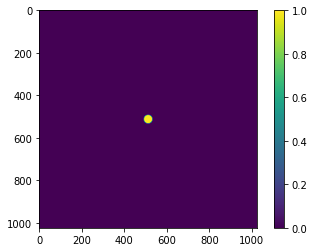

In [7]:
#Abertura circular

mask = np.zeros((1024,1024), dtype = "uint8")
coord_prev = np.shape(mask)
coord = int(coord_prev[0]/2)
print (coord)
cv2.circle(mask, (coord, coord), 20, 1, -1)
plt.imshow(mask)
plt.colorbar()
plt.show()

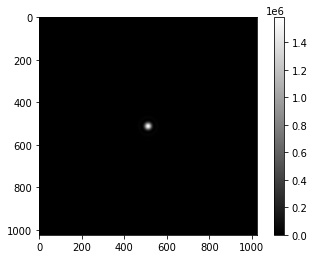

(1024, 1024)

In [8]:
propFresnelC = Fresnel(mask, w_length, 5*um, dx, dy)
fun_ploteo_complejo(propFresnelC, "I", 1)
np.shape(propFresnelC)

Prueba de espectro angular usando una abertura circular

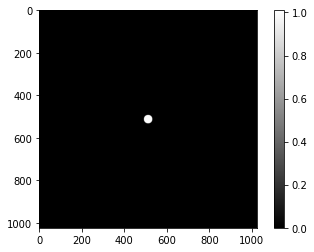

(1024, 1024)

In [11]:
propASC = EspectroAngular(mask, w_length, 0.4*um, dx, dy)
fun_ploteo_complejo(propASC, "I", 1)
np.shape(propASC)

Prueba de Transformada de Fresnel usando una abertura rectangular

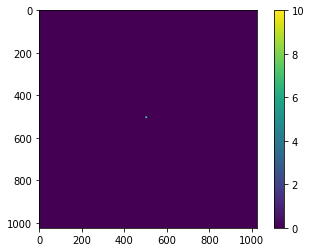

In [12]:
mask2 = np.zeros((1024,1024), np.uint8)
cv2.rectangle(mask2, (506,506), (500,500),10, -1)
plt.figure()
plt.imshow(mask2)
plt.colorbar()
plt.show()

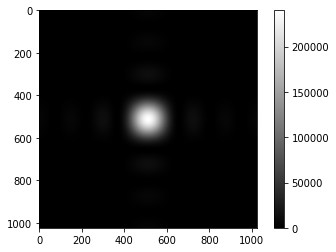

In [14]:
propFresnelR = Fresnel(mask2, w_length, 1*mm, dx, dy)
fun_ploteo_complejo(propFresnelR, "I", 1)

Prueba de Espectro Angular usando una abertura rectangular

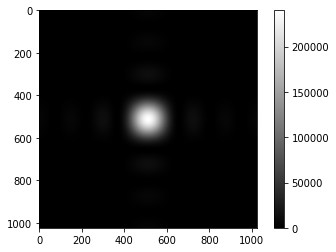

In [13]:
propASR = Fresnel(mask2, w_length, 0.4*um, dx, dy)
fun_ploteo_complejo(propASR, "I", 1)